## Shopping Cart Abandonment
## Transformer
Code References:

https://www.tensorflow.org/text/tutorials/transformer

https://medium.com/@max_garber/simple-keras-transformer-model-74724a83bb83

In [ ]:
!wget https://github.com/mease/csci5502-cart-abandonment/raw/main/data/cart_abandon_data_seq_30.zip
!mkdir data
!unzip cart_abandon_data_seq_30.zip -d data

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer, Add, MultiHeadAttention, GlobalAveragePooling1D, Conv1D, Input, Embedding, Concatenate, LayerNormalization, Dense, Dropout

import numpy as np

In [2]:
with open('data/X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('data/y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('data/X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('data/y_test.npy', 'rb') as f:
    y_test = np.load(f)

In [3]:
time_vocab_size = len(np.unique(np.concatenate((np.unique(X_train[:,:,0]),np.unique(X_test[:,:,0])))))
item_vocab_size = len(np.unique(np.concatenate((np.unique(X_train[:,:,1]),np.unique(X_test[:,:,1])))))
cat_vocab_size = len(np.unique(np.concatenate((np.unique(X_train[:,:,2]),np.unique(X_test[:,:,2])))))
print(f"Time vocab: {time_vocab_size}, Item vocab: {item_vocab_size}, Category vocab: {cat_vocab_size}")

Time vocab: 4369, Item vocab: 51758, Category vocab: 335


In [4]:
sequence_length = 30

In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, enc_len, seq_len, name=None):
        super(PositionalEncoding, self).__init__(name=name)

        self.enc_len = enc_len
        self.seq_len = seq_len
        
        angle_rads = self.get_angles(np.arange(self.seq_len)[:, np.newaxis],
                                     np.arange(self.enc_len)[np.newaxis, :])

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.pos_encoding = angle_rads[np.newaxis, ...]
        self.pos_encoding = tf.cast(self.pos_encoding, dtype=tf.float32)
    
    def get_angles(self, pos, i):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(self.enc_len))
        return pos * angle_rates
    
    def call(self, x, training, mask=None):
        x *= tf.math.sqrt(tf.cast(self.enc_len, tf.float32))
        x += self.pos_encoding[:, :self.seq_len, :]
        return x
    
    def compute_mask(self, inputs, mask=None):
        return mask

In [6]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, enc_len, num_heads, head_size, ff_dim, dropout=0, name=None):
        super(TransformerEncoder, self).__init__(name=name)
        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.mha = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)
        self.drop1 = Dropout(dropout)
        self.ln2 = LayerNormalization(epsilon=1e-6)
        self.ff1 = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")
        self.drop2 = Dropout(dropout)
        self.ff2 = Conv1D(filters=enc_len, kernel_size=1)

    def call(self, x, training, mask=None):
        inputs = x
        x = self.ln1(x)
        x = self.mha(x, x)
        x = self.drop1(x)
        res = x + inputs
        x = self.ln2(res)
        x = self.ff1(x)
        x = self.drop2(x)
        x = self.ff2(x)
        x = x + res
        return x
    
    def compute_mask(self, inputs, mask=None):
        return mask

In [7]:
# Hyperparameters
num_heads = 4            # Number of attention heads
head_size = 256          # Attention head size
ff_dim = 4               # Encoder feed-forward size
enc_dropout = 0.1        # Encoder dropout
out_linear_size = 256    # Linear output layer size
out_linear_dropout = 0.1 # Linear output layer dropout
encoder_layers = 3       # Number of transformer encoder layers
learning_rate = 1e-3     # Optimizer learning rate
batch_size = 1024        # Training batch size
epochs = 3               # Number of epochs to train

In [8]:
# Timestamp input and embedding
time_inp = Input(shape=(sequence_length,), name='time_input')
time_emb = Embedding(output_dim=10,
                     input_dim=time_vocab_size,
                     input_length=sequence_length,
                     embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.075, maxval=0.075),
                     mask_zero=True,
                     name='time_embedding')(time_inp)

# Item ID input and embedding
item_inp = Input(shape=(sequence_length,), name='item_input')
item_emb = Embedding(output_dim=100,
                     input_dim=item_vocab_size,
                     input_length=sequence_length,
                     embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.075, maxval=0.075),
                     mask_zero=True,
                     name='item_embedding')(item_inp)

# Category input and embedding
cat_inp = Input(shape=(sequence_length,), name='category_input')
cat_emb = Embedding(output_dim=10,
                    input_dim=cat_vocab_size,
                    input_length=sequence_length,
                    embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-0.075, maxval=0.075),
                    mask_zero=True,
                    name='category_embedding')(cat_inp)

# Concatenate embeddings
embedding = Concatenate(axis=2, name='concat_embeddings')([time_emb, item_emb, cat_emb])

x = PositionalEncoding(enc_len=embedding.shape[-1],
                       seq_len=sequence_length,
                       name='pos_encoding')(embedding)

# Transformer Encoder layers
for i in range(encoder_layers):
    x = TransformerEncoder(enc_len=embedding.shape[-1],
                           num_heads=num_heads,
                           head_size=head_size,
                           ff_dim=ff_dim,
                           dropout=enc_dropout,
                           name=f"encoder_{i+1}")(x)

x = GlobalAveragePooling1D(name='pooling')(x)
x = Dense(out_linear_size, activation="relu", name='linear_1')(x)
x = Dropout(out_linear_dropout)(x)
out = Dense(1, activation="sigmoid", name='linear_2')(x)


model = Model(inputs=[time_inp, item_inp, cat_inp], outputs=[out])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn'),
                       keras.metrics.BinaryAccuracy(name='accuracy'),
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       keras.metrics.AUC(name='auc')])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 category_input (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 time_embedding (Embedding)     (None, 30, 10)       43690       ['time_input[0][0]']             
                                                                                              

In [9]:
model.fit(
    [X_train[:,:,0], X_train[:,:,1], X_train[:,:,2]], y_train,
    validation_data=([X_test[:,:,0], X_test[:,:,1], X_test[:,:,2]], y_test),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/3
7209/7209 [==============================] - 2057s 284ms/step - loss: 0.1788 - tp: 5741.0000 - fp: 6470.0000 - tn: 6972773.0000 - fn: 396871.0000 - accuracy: 0.9454 - precision: 0.4701 - recall: 0.0143 - auc: 0.7939 - val_loss: 0.1745 - val_tp: 2001.0000 - val_fp: 1668.0000 - val_tn: 1743143.0000 - val_fn: 98652.0000 - val_accuracy: 0.9456 - val_precision: 0.5454 - val_recall: 0.0199 - val_auc: 0.8119
Epoch 2/3
7209/7209 [==============================] - 2052s 285ms/step - loss: 0.1708 - tp: 11273.0000 - fp: 9446.0000 - tn: 6969797.0000 - fn: 391339.0000 - accuracy: 0.9457 - precision: 0.5441 - recall: 0.0280 - auc: 0.8242 - val_loss: 0.1729 - val_tp: 3115.0000 - val_fp: 2742.0000 - val_tn: 1742069.0000 - val_fn: 97538.0000 - val_accuracy: 0.9457 - val_precision: 0.5318 - val_recall: 0.0309 - val_auc: 0.8200
Epoch 3/3
7209/7209 [==============================] - 2053s 285ms/step - loss: 0.1663 - tp: 18091.0000 - fp: 14435.0000 - tn: 6964808.0000 - fn: 384521.0000 - accuracy:

In [10]:
prediction = model.predict([X_test[:,:,0], X_test[:,:,1], X_test[:,:,2]])
y_pred = (prediction > 0.5)

In [11]:
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9473    0.9979    0.9720   1744811
           1     0.5170    0.0382    0.0711    100653

    accuracy                         0.9456   1845464
   macro avg     0.7321    0.5181    0.5215   1845464
weighted avg     0.9239    0.9456    0.9228   1845464



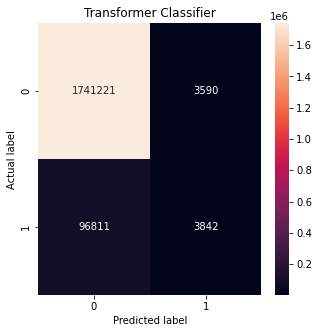

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Transformer Classifier")
plt.show()